$$
{\huge \text{Model selection bias: sample size and coefficients}}
$$

$$
{\scriptsize \text{Massimo Pierini, 2025}}
$$

It is well known that model selection procedures invalidate classical inference on the parameters of the selected model (Berk 2010, 2013; Leeb 2005; Pötscher 1991).

The aim of this notebook is to provide a simple and fully reproducible simulation to verify that a "big enough" sample size and "true" coefficients "enough" different from zero can reduce the effect of the model selection bias.

# INTRODUCTION

In this simple simulation, we'll experimentally verify that, even though a model selection procedure distorts the distribution of the estimators so that the classical inference cannot be safely applied anymore to the selected model, a "big enough" sample size and "true" coefficients "enough" different from zero can reduce the effect of the model selection bias.

We'll use a modified version of the "Simulations of Model-Selection", section 4 of "Statistical Inference After Model Selection" (Berk 2010).

# DEFINITION

For this simulation, the full regression model takes the form of

\begin{equation}
y_i = \beta_0 + \beta_w w_i + \beta_x x_i + \beta_z z_i + \varepsilon_i
\end{equation}
where

\begin{equation}
\left\{
\begin{array}{l}
\beta_0 = 3.0
\\
\beta_w = 1.0
\\
\beta_x = 2.0
\\
\beta_z = 4.0
\end{array}
\right.
\end{equation}

and $\varepsilon_i \overset{iid}{\sim} N(0, \sigma_\varepsilon^2)$.

Because all the parameters $\beta_i \neq 0$ in equation $(1)$, many would refer to a submodel that included all parameters as
the “correct” model. Therefore, we will use the adjective “preferred” for the model with all parameters included.

All three predictors are drawn at random from a multivariate normal
distribution with null means.

The
variances and covariances are set as follows: 
$\sigma_\varepsilon^2 = 10.0$, 
$\sigma_w^2 = 5.0$, 
$\sigma_x^2 = 6.0$,
$\sigma_z^2 = 7.0$, 
$\sigma_{w,x} = 4.0$, 
$\sigma_{w,z} = 5.0$, 
and $\sigma_{x,z} = 5.0$,
therefore leading to the following covariance matrix $\Sigma$

\begin{equation}
\Sigma = 
\begin{bmatrix}
5 & 4 & 5
\\
4 & 6 & 5
\\
5 & 5 & 7
\end{bmatrix}
\end{equation}

The sample size will be 1000.

10,000 samples will be drawn, forward stepwise regression minimizing AIC applied to each, and sampling distributions will be constructed from the final models selected. In addition to plotting estimated regression coeﬃcients, conventional t-values will be plotted. The usual null hypothesis will be assumed; each regression coeﬃcient has
a population value $0.0$. 

A distribution of t-values is more informative than
a distribution of regression coeﬃcients because it takes the regression coeﬃcients and their standard errors into account (Berk 2009).

# SIMULATIONS

First of all, let's make the needed imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm.notebook import tqdm

and define the "true" coefficients, variances, covariances, and sample size. We'll set a seed (`random_state`) to ensure reproducibility.

In [214]:
# true model coefficients
beta0 = 3.0
betaw = 1.0
betax = 2.0
betaz = 4.0
N = 1000
# random errors distribution
epsilon = sps.norm(loc=0, scale=np.sqrt(10.0))
# predictors drawing from a multinormal distribution
X = sps.multivariate_normal(mean=[0, 0, 0], cov=[
    [ 5,  4,  5],
    [ 4,  6,  5],
    [ 5,  5,  7]
]).rvs(N, random_state=42)

Let's now draw a sample of $Y$ using model $(1)$ and take a look at a pairplot of the resulting data.

In [215]:
Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=1976)

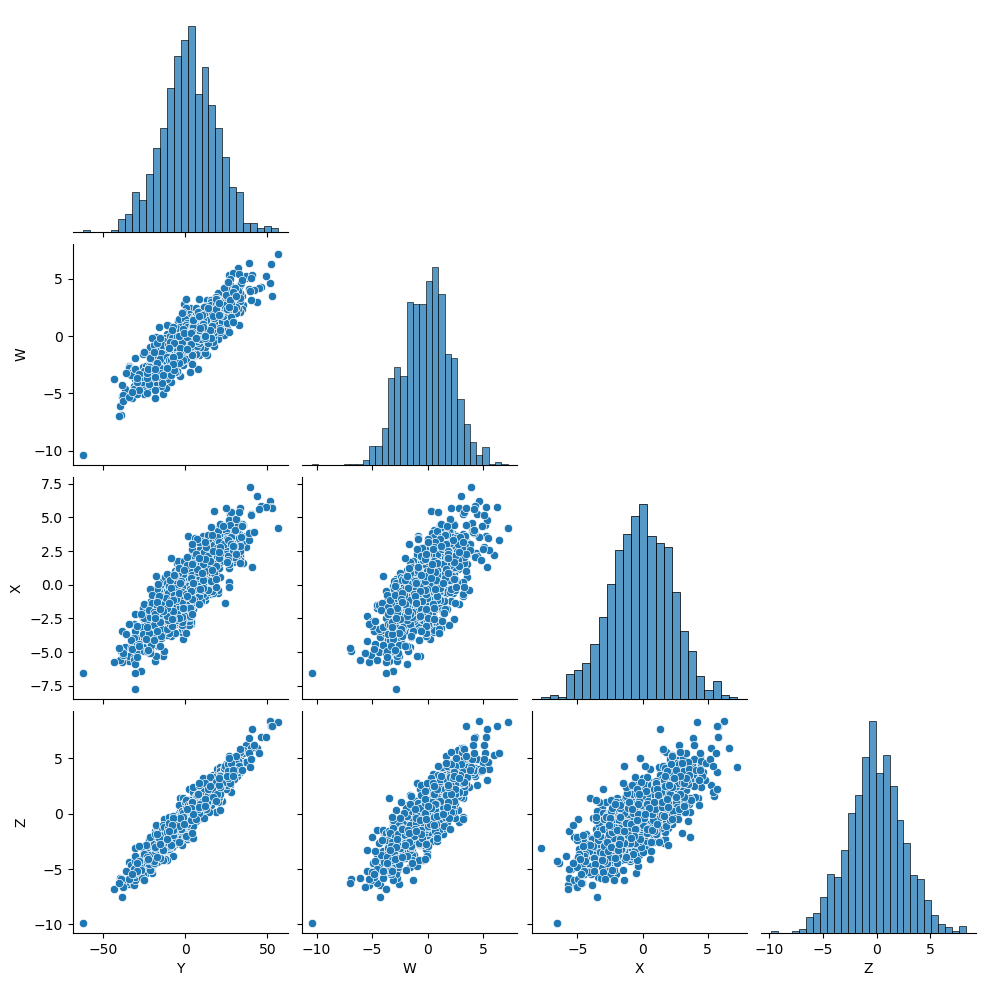

In [216]:
df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
sns.pairplot(df, corner=True)
plt.show()

In [217]:
sm.OLS.from_formula("Y ~ 1", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 29 Sep 2025   Prob (F-statistic):                nan
Time:                        19:35:38   Log-Likelihood:                -4223.4
No. Observations:                1000   AIC:                             8449.
Df Residuals:                     999   BIC:                             8454.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1855      0.523      4.182      0.000       1.160       3.211
==============================================================================
Omnibus:                        1.107   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                0.989
Skew:                          -0.021   Prob(JB):                        0.610
Kurtosis:                       3.148   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now define the forward stepwise selection procedure (modified from https://ujangriswanto08.medium.com/mastering-stepwise-linear-regression-in-python-from-theory-to-practice-d7293d635240).

In [218]:
def forward_selection(X, y, verbose=False):
    selected_features = []
    remaining_features = list(X.columns)
    model = sm.OLS.from_formula("Y ~ 1", data=pd.DataFrame({"Y": y})).fit() # null model, intercept only
    best_aic = model.aic

    if verbose: print("------------ START -------------")
    while remaining_features:
        if verbose: print(f"Selected features:  {selected_features}")
        if verbose: print(f"Remaining features: {remaining_features}")
        aic_with_candidates = []
        
        for candidate in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [candidate]])).fit()
            if verbose: print(f"  AIC of {candidate}: {model.aic}")
            aic_with_candidates.append((model.aic, candidate))
        
        aic_with_candidates.sort()  # Sort by AIC
        best_new_aic, best_candidate = aic_with_candidates[0]
        if verbose: print(f"    Best: {best_candidate} (AIC: {best_new_aic})")

        if best_new_aic < best_aic:
            if verbose: print("    BEST NEW AIC less than PREVIOUS")
            best_aic = best_new_aic
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            if verbose: print("    BEST NEW AIC greater than PREVIOUS")
            break
    if verbose: print(f"SELECTED MODEL: {selected_features}")
    if verbose: print("------------ END -------------")
    return selected_features, remaining_features

Let's now start the simulation, collecting: 

- the parameter estimates for each selected model and for the preferred model
- the t-test statistics for each selected model and for the preferred model
- the $R^2$ coefficient of determination for each selected model and for the preferred model

We'll set a seed for each drawing to ensure reproducibility.

Notice we do not (and we do not need nor want to) take other samples of the predictors: the predictors are not random variables, they're fixed and known without errors. $\pmb Y$ is a random variable, because of the identically and independently distributed random errors $\pmb \varepsilon$.

In [219]:
# samples numnber
rep = 10000
# init results
models = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
pref_model = {
    "beta_0": [],
    "beta_w": [],
    "beta_x": [],
    "beta_z": [],
    "tval_0": [],
    "tval_W": [],
    "tval_X": [],
    "tval_Z": [],
    "R2": []
}
# simulation
for i in tqdm(range(rep)):
    # draw a sample of Y given equation (1)
    Y = beta0 + betaw*X[:,0] + betax*X[:,1] + betaz*X[:,2] + epsilon.rvs(N, random_state=i)
    df = pd.DataFrame({
        "Y":Y, "W": X[:,0], "X": X[:,1], "Z": X[:,2]
    })
    # bootstrapping
    # _df = df.iloc[np.random.choice(df.index, size=500, replace=True)].reset_index()
    # preferred model
    pmod = sm.OLS.from_formula("Y ~ W + X + Z", data=df).fit()
    # collect t-test statistics and R-squared
    pref_model["beta_0"].append(pmod.params.Intercept)
    pref_model["beta_w"].append(pmod.params.W)
    pref_model["beta_x"].append(pmod.params.X)
    pref_model["beta_z"].append(pmod.params.Z)
    pref_model["tval_0"].append(pmod.tvalues.Intercept)
    pref_model["tval_W"].append(pmod.tvalues.W)
    pref_model["tval_X"].append(pmod.tvalues.X)
    pref_model["tval_Z"].append(pmod.tvalues.Z)
    pref_model["R2"].append(pmod.rsquared)
    # prepare data for model selection
    x = df.drop('Y', axis=1)  # Features
    y = df['Y']               # Target variable
    # forward stepwise model selection
    selected_features, remaining_features = forward_selection(x, y)
    # selected model
    mod = sm.OLS.from_formula("Y ~ " + " + ".join(selected_features), data=df).fit()
    # if len(remaining_features):
    #     dom = sm.OLS.from_formula("Y ~ " + " + ".join(remaining_features), data=df).fit()
    # else:
    #     dom = sm.OLS.from_formula("Y ~ 1", data=df).fit()
    # collect t-test statistics and R-squared
    models["tval_0"].append(mod.tvalues.Intercept)
    models["beta_0"].append(mod.params.Intercept)
    if "W" in selected_features:
        models["tval_W"].append(mod.tvalues.W)
        models["beta_w"].append(mod.params.W)
    else:
        models["tval_W"].append(None)
        models["beta_w"].append(None)
    if "X" in selected_features:
        models["tval_X"].append(mod.tvalues.X)
        models["beta_x"].append(mod.params.X)
    else:
        models["tval_X"].append(None)
        models["beta_x"].append(None)
    if "Z" in selected_features:
        models["tval_Z"].append(mod.tvalues.Z)
        models["beta_z"].append(mod.params.Z)
    else:
        models["tval_Z"].append(None)
        models["beta_z"].append(None)
    models["R2"].append(mod.rsquared)

  0%|          | 0/10000 [00:00<?, ?it/s]

# RESULTS

Let's define `DataFrame`s of the results.

In [220]:
DF = pd.DataFrame(models)
DF

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,2.868342,1.207670,1.966551,3.861098,29.004813,13.845977,30.165362,50.281544,0.964310
1,3.117413,0.943508,2.043027,3.982349,31.645110,10.859100,31.459409,52.060725,0.964372
2,2.852528,0.979516,2.102081,3.953989,28.298833,11.017573,31.633854,50.516421,0.963280
3,3.063876,1.188457,1.966804,3.866434,30.310299,13.330264,29.515096,49.259290,0.962667
4,3.166659,1.065939,1.975758,3.970874,33.112557,12.637462,31.339299,53.473195,0.966636
...,...,...,...,...,...,...,...,...,...
9995,2.920482,1.071542,1.940068,4.011271,30.484635,12.681535,30.719032,53.922126,0.966686
9996,3.051889,1.093817,2.061796,3.899647,30.678294,12.466467,31.439260,50.483139,0.964204
9997,2.918598,1.196439,1.966081,3.878879,29.356733,13.644574,29.998453,50.245620,0.964039
9998,2.934778,0.992001,2.006873,3.972091,28.935812,11.089416,30.015424,50.435714,0.962287


In [221]:
PR = pd.DataFrame(pref_model)
PR

,beta_0,beta_w,beta_x,beta_z,tval_0,tval_W,tval_X,tval_Z,R2
0,2.868342,1.207670,1.966551,3.861098,29.004813,13.845977,30.165362,50.281544,0.964310
1,3.117413,0.943508,2.043027,3.982349,31.645110,10.859100,31.459409,52.060725,0.964372
2,2.852528,0.979516,2.102081,3.953989,28.298833,11.017573,31.633854,50.516421,0.963280
3,3.063876,1.188457,1.966804,3.866434,30.310299,13.330264,29.515096,49.259290,0.962667
4,3.166659,1.065939,1.975758,3.970874,33.112557,12.637462,31.339299,53.473195,0.966636
...,...,...,...,...,...,...,...,...,...
9995,2.920482,1.071542,1.940068,4.011271,30.484635,12.681535,30.719032,53.922126,0.966686
9996,3.051889,1.093817,2.061796,3.899647,30.678294,12.466467,31.439260,50.483139,0.964204
9997,2.918598,1.196439,1.966081,3.878879,29.356733,13.644574,29.998453,50.245620,0.964039
9998,2.934778,0.992001,2.006873,3.972091,28.935812,11.089416,30.015424,50.435714,0.962287


Let's plot the distribution (KDE) of $R^2$ for both the selected models and the preferred model.

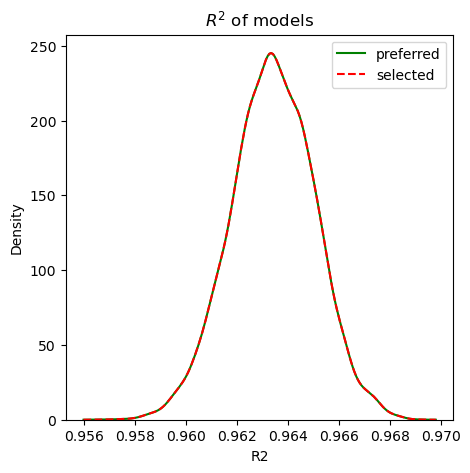

In [222]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(PR.R2, label="preferred", color="g")
sns.kdeplot(DF.R2, label="selected", color="r", ls="--")
plt.legend()
plt.title("$R^2$ of models")
plt.show()

Although optimum, we do not care here for the value itself but for the distribution.

We can clearly see that the coefficient of determinations are likely very similar. We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the two samples have been drawn from the same distribution.

In [223]:
sps.ks_2samp(DF.R2, PR.R2, nan_policy="raise", alternative="two-sided")

/Users/massimopierini/anaconda3/envs/advanced-forecasting/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


KstestResult(statistic=0.0001, pvalue=1.0, statistic_location=0.9634612544347119, statistic_sign=1)

Indeed, the $p$-value is $\gg .05$ so we fail to reject the null hypothesis. This confirms the visual inspection.

Let's now compute the absolute and relative frequencies of the 8 possible models, selected by the forward stepwise procedure.

In [224]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size]
})
perc_selection.style.hide(axis="index").set_caption("SELECTED MODELS ABSOLUTE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0,0,0,0,0,0,0,10000


In [225]:
perc_selection = pd.DataFrame({
    "null": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "W": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "X": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "Z": [DF[(DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WX": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(DF.tval_Z.isna())].index.size/rep],
    "WZ": [DF[(~DF.tval_W.isna())&(DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "XZ": [DF[(DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep],
    "WXZ": [DF[(~DF.tval_W.isna())&(~DF.tval_X.isna())&(~DF.tval_Z.isna())].index.size/rep]
})
perc_selection.style.hide(axis="index").format('{:.2%}').set_caption("SELECTED MODELS RELATIVE FREQUENCIES")

null,W,X,Z,WX,WZ,XZ,WXZ
0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%


We see that

- the preferred model has been selected approx. $100\%$ of the times

Let's take a look at the relative frequencies of each predictor having been included in the selected model.

In [234]:
perc_predictor = pd.DataFrame({
    "W": [DF[(~DF.tval_W.isna())].index.size/rep],
    "X": [DF[(~DF.tval_X.isna())].index.size/rep],
    "Z": [DF[(~DF.tval_Z.isna())].index.size/rep]
})
perc_predictor.style.hide(axis="index").format('{:.2%}').set_caption("INCLUDED PREDICTORS RELATIVE FREQUENCIES")

W,X,Z
100.00%,100.00%,100.00%


This confirms that all predictors have been included $100\%$ of the times.

Let's now plot the distributions (KDE) of the parameters' estimates for both the preferred and the selected models.

For the selected models, the distributions for each predictor's parameter are conditional on the predictor having been included in the selected model.

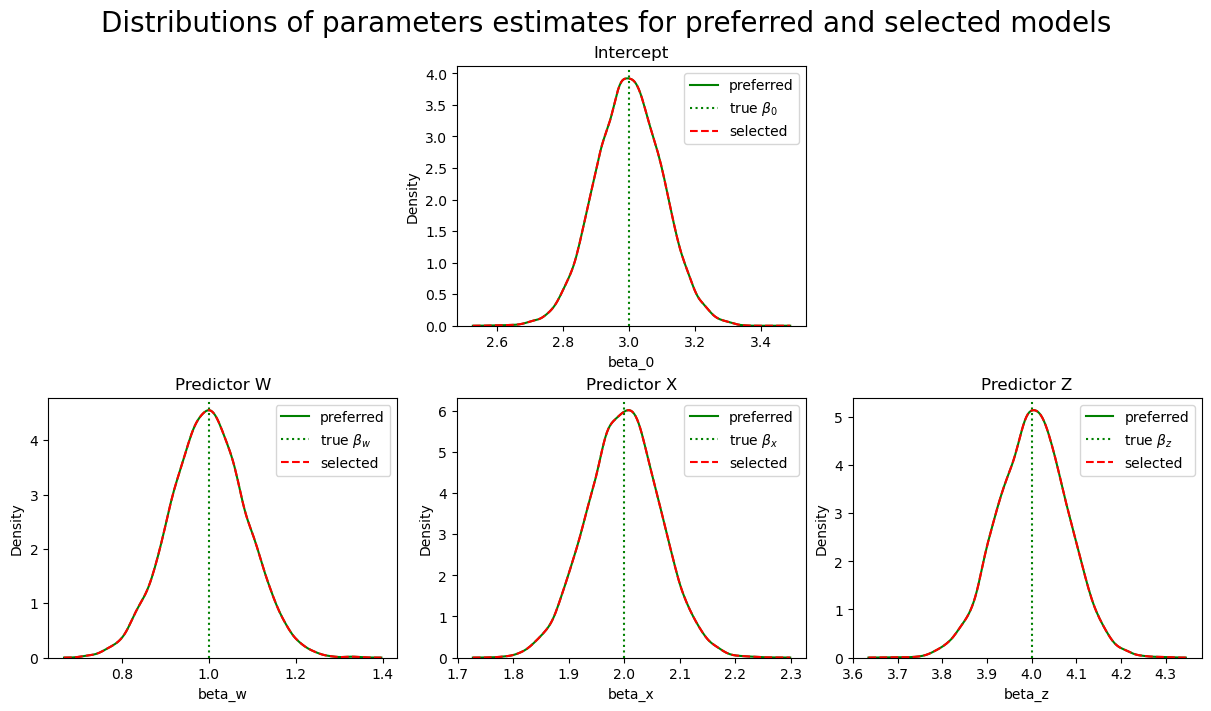

In [227]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.beta_0, label="preferred", color="g", ax=ax[0,1])
ax[0,1].axvline(beta0, color="g", ls=":", label=r"true $\beta_0$")
sns.kdeplot(DF.beta_0, label="selected", color="r", ls="--", ax=ax[0,1])
# sns.kdeplot(FD.beta_0, label="excluded", color="y", ls=":", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.beta_w, label="preferred", color="g", ax=ax[1,0])
ax[1,0].axvline(betaw, color="g", ls=":", label=r"true $\beta_w$")
sns.kdeplot(DF.beta_w, label="selected", color="r", ls="--", ax=ax[1,0])
# sns.kdeplot(FD.beta_w, label="excluded", color="y", ls=":", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.beta_x, label="preferred", color="g", ax=ax[1,1])
ax[1,1].axvline(betax, color="g", ls=":", label=r"true $\beta_x$")
sns.kdeplot(DF.beta_x, label="selected", color="r", ls="--", ax=ax[1,1])
# sns.kdeplot(FD.beta_x, label="excluded", color="y", ls=":", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.beta_z, label="preferred", color="g", ax=ax[1,2])
ax[1,2].axvline(betaz, color="g", ls=":", label=r"true $\beta_z$")
sns.kdeplot(DF.beta_z, label="selected", color="r", ls="--", ax=ax[1,2])
# sns.kdeplot(FD.beta_z, label="excluded", color="y", ls=":", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of parameters estimates for preferred and selected models", fontsize=20)

plt.show()

We notice that

- all distribution seem 'enough' normal and very similar

We could also perform Shapiro-Wilk tests to test the null hypothesis that the observed parameters' estimates have been drawn from a normal distribution.

In [228]:
sps.shapiro(DF.beta_w.dropna()), sps.shapiro(DF.beta_x.dropna()), sps.shapiro(DF.beta_z.dropna())

/Users/massimopierini/anaconda3/envs/advanced-forecasting/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.9997364195124838, pvalue=0.233387545682194),
 ShapiroResult(statistic=0.9998280973262704, pvalue=0.6614861876439055),
 ShapiroResult(statistic=0.9997329989257733, pvalue=0.22295420671226152))

In [229]:
sps.shapiro(PR.beta_w.dropna()), sps.shapiro(PR.beta_x.dropna()), sps.shapiro(PR.beta_z.dropna())

(ShapiroResult(statistic=0.9997364195124849, pvalue=0.23338754568542874),
 ShapiroResult(statistic=0.9998280973262708, pvalue=0.6614861876454746),
 ShapiroResult(statistic=0.9997329989257738, pvalue=0.22295420671399102))

We see that we fail to reject the null hypothesis for all parameters' estimates of the preferred model. This confirms what the visual inspection.

Let's now plot the distributions (KDE) of t-test statistics of each predictor for both the selected and the preferred model.

For the selected models, the distributions of the t-test statistics for each predictor's parameter are conditional on the predictor having been included in the selected model.

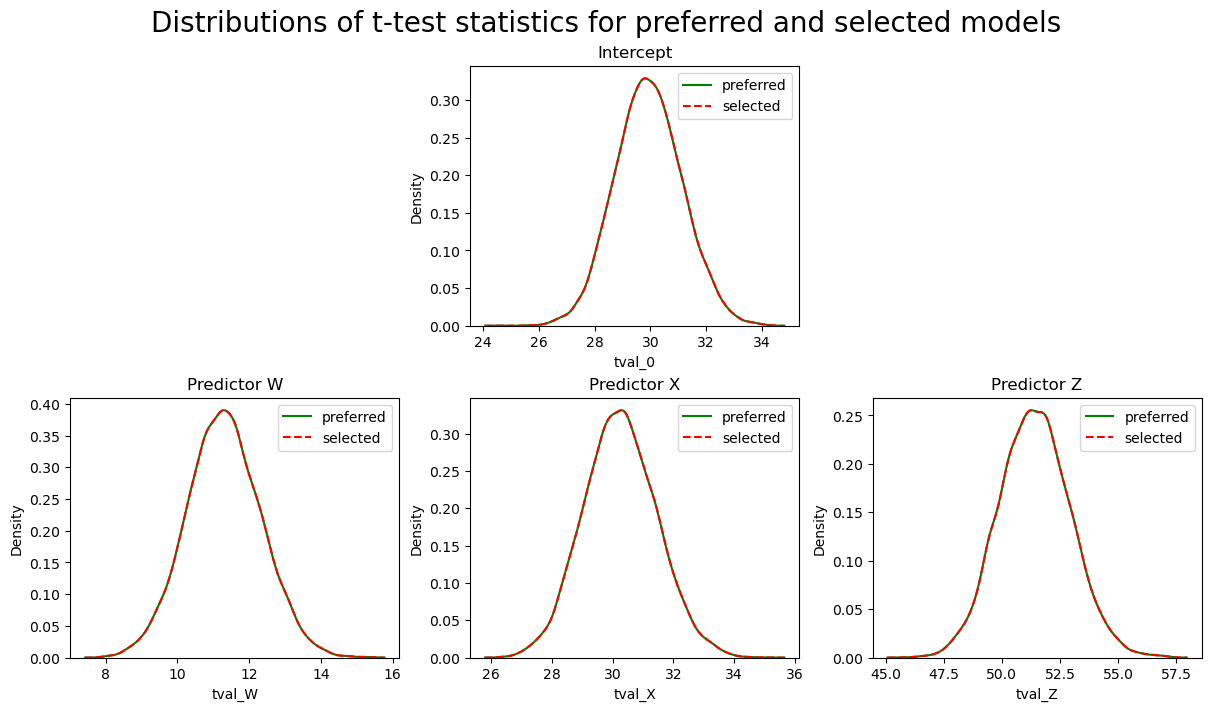

In [230]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7), layout="constrained")

ax[0,0].axis(False)
ax[0,2].axis(False)

sns.kdeplot(PR.tval_0, label="preferred", color="g", ax=ax[0,1])
sns.kdeplot(DF.tval_0, label="selected", color="r", ls="--", ax=ax[0,1])
ax[0,1].legend()
ax[0,1].set_title("Intercept")

sns.kdeplot(PR.tval_W, label="preferred", color="g", ax=ax[1,0])
sns.kdeplot(DF.tval_W, label="selected", color="r", ls="--", ax=ax[1,0])
ax[1,0].legend()
ax[1,0].set_title("Predictor W")

sns.kdeplot(PR.tval_X, label="preferred", color="g", ax=ax[1,1])
sns.kdeplot(DF.tval_X, label="selected", color="r", ls="--", ax=ax[1,1])
ax[1,1].legend()
ax[1,1].set_title("Predictor X")

sns.kdeplot(PR.tval_Z, label="preferred", color="g", ax=ax[1,2])
sns.kdeplot(DF.tval_Z, label="selected", color="r", ls="--", ax=ax[1,2])
ax[1,2].legend()
ax[1,2].set_title("Predictor Z")

fig.suptitle("Distributions of t-test statistics for preferred and selected models", fontsize=20)

plt.show()

We can notice that

- all distributions seem quite similar

We could also perform a two-samples Kolmogorov-Smirnov test to test the null hypothesis that the samples (for $X$ and $Z$) have been drawn from the same distribution.

In [231]:
sps.ks_2samp(DF.tval_W.dropna(), PR.tval_W, nan_policy="raise")

/Users/massimopierini/anaconda3/envs/advanced-forecasting/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


KstestResult(statistic=0.0001, pvalue=1.0, statistic_location=11.284139262443496, statistic_sign=1)

In [232]:
sps.ks_2samp(DF.tval_X.dropna(), PR.tval_X, nan_policy="raise")

KstestResult(statistic=0.0001, pvalue=1.0, statistic_location=30.237471303817834, statistic_sign=1)

In [233]:
sps.ks_2samp(DF.tval_Z.dropna(), PR.tval_Z, nan_policy="raise")

KstestResult(statistic=0.0001, pvalue=1.0, statistic_location=51.39677232971836, statistic_sign=1)

In all cases, we definitely fail to reject the null hypothesis. This confirms the visual inspection.

# CONCLUSIONS

As pointed out by Berk (2010) and many other Authors who have deeply studied the model selection bias, we have experimentally verified that the model selection procedure distorts the estimators' distributions, invalidating the classical inference on the selected model.

This happens because, as a result of the model selection procedure, the model itself is not "fixed" anymore but becomes a random variable itself (Berk 2013), potentially having dramatic effects on the estimators' distributions, as in the simulation we performed.

If, although, the sample size is 'large enough' and all true coefficients are 'enough' different from zero, the effect of the model selection bias is minimum. In this simulation, the preferred model has been selected $100\%$ of the times, so we can see no bias at all.

# ESSENTIAL BIBLIOGRAPHY

Berk, R., Brown, L., & Zhao, L. (2010). Statistical inference after model selection. _Journal of Quantitative Criminology, 26(2)_, 217-236.

Berk, R., Brown, L., Buja, A., Zhang, K., & Zhao, L. (2013). Valid post-selection inference. _The Annals of Statistics_, 802-837.

Leeb, H., & Pötscher, B. M. (2005). Model selection and inference: Facts and fiction. _Econometric Theory, 21(1)_, 21-59.

Pötscher, B. M. (1991). Effects of model selection on inference. _Econometric Theory, 7(2)_, 163-185.

Many other papers, even more recent, can be found in the literature. A Bayesian simulation can be found at https://josue.rbind.io/post/model-selection-bias/.